# [](http://)Modelling Stock Volatility with Ornstein-Uhlenbeck process

In [28]:
## installing or upgrading pandas datareader
# !pip install --upgrade pandas_datareader

In [29]:
# Import dependencies
import time
import math
import numpy as np
import pandas as pd
import datetime
import scipy as sc
import matplotlib.pyplot as plt
from pandas_datareader import data as pdr
from IPython.display import display, Latex
from statsmodels.graphics.tsaplots import plot_acf

In [31]:
# importing data
stock_prices = pd.read_csv('/kaggle/input/nepse-datas/datas/NABIL.csv')
date = stock_prices['date']
endDate = pd.to_datetime(date.iat[-1])
startDate = pd.to_datetime(date.iat[0])
print(startDate)
stock_prices.head()

2011-07-17 05:45:00


,open,high,low,close,volume,date
0,108.29,116.76,108.29,116.76,177.0,2011-07-17 05:45:00
1,119.05,119.56,106.68,108.78,1584.0,2011-07-18 05:45:00
2,108.96,112.01,108.96,112.01,1301.0,2011-07-19 05:45:00
3,114.21,116.42,112.43,114.98,814.0,2011-07-20 05:45:00
4,114.04,117.01,114.04,116.17,1285.0,2011-07-21 05:45:00


### Volatility clustering in financial time series

<i>Paper</i>: Volatility Clustering in Financial Markets:Empirical Facts and Agent–Based Models, Rama Cont. 2005.

The study of statistical properties of financial time series:
 - <b>Excess volatility</b>
 - <b>Heavy Tails</b>
 - <b>Volatilty clustering</b>

As noted by Mandelbrot [1], “large changes tend to be followed by large changes, of either sign, and small changes tend to be followed by small changes.”
A quantitative manifestation of this fact is that, while returns themselves are uncorrelated, absolute returns $|r_t|$ or their squares display a positive, significant and slowly decaying autocorrelation function: $corr(|r_t|, |r_t+\tau|) > 0$ for $\tau$ ranging from a few minutes to a several weeks.

[1] B. B. Mandelbrot (1963) The variation of certain speculative prices, Journal of Business, XXXVI (1963), pp. 392–417.

Denote by $S_t$ the price of a financial asset and $X_t = ln S_t$ its logarithm. Given a time scale $\Delta$, the log
return at scale $\Delta$ is defined as:

<center>$r_t = X_{t+\Delta} - X_t = ln(S_t+\Delta S_t)$</center>

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


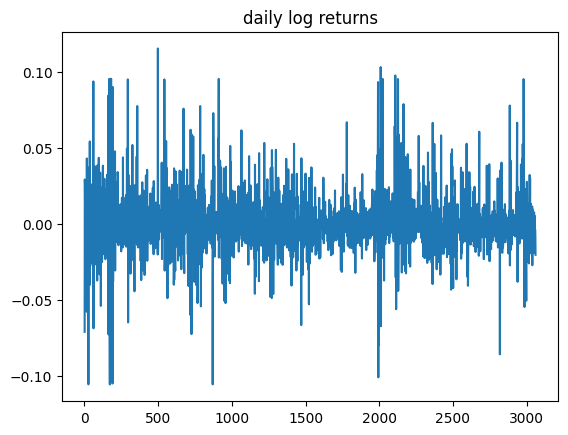

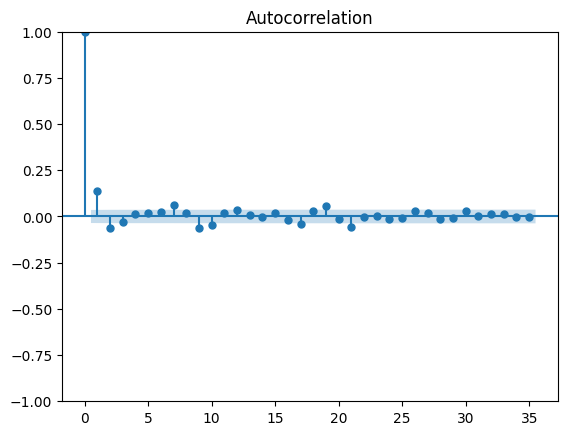

In [32]:
log_returns = np.log(stock_prices.close/stock_prices.close.shift(1)).dropna()
log_returns.plot()
plt.title('daily log returns')
plot_acf(log_returns)
plt.show()

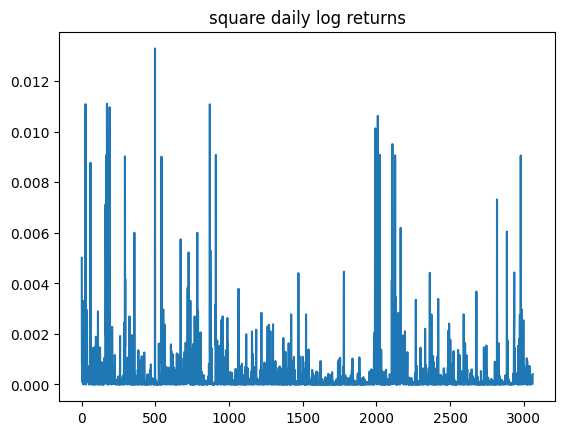

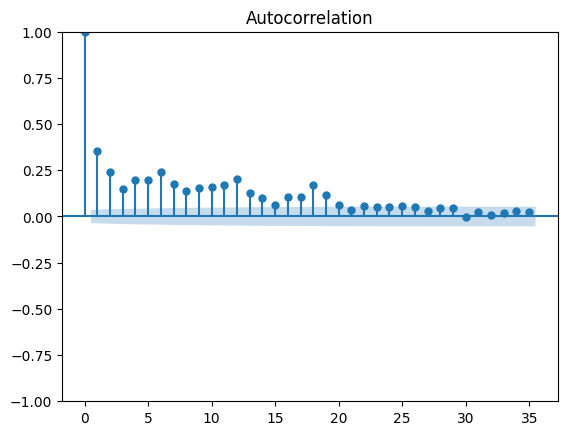

In [33]:
log_returns_sq = np.square(log_returns)
log_returns_sq.plot()
plt.title('square daily log returns')
plot_acf(log_returns_sq)
plt.show()

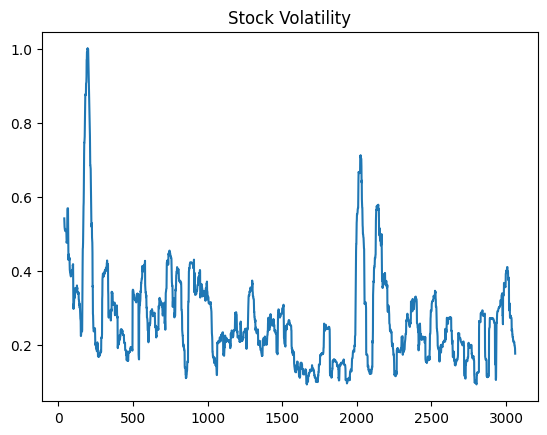

In [34]:
TRADING_DAYS = 40
volatility = log_returns.rolling(window=TRADING_DAYS).std()*np.sqrt(252)
volatility = volatility.dropna()
volatility.plot()
plt.title('Stock Volatility')
plt.show()

## Ornstein-Uhlenbeck

Ornstein-Uhlenbeck is a stochastic process that is a stationary Gauss-Markov process.

${\displaystyle dX_{t}=-\kappa \,X_{t}\,dt+\sigma \,dW_{t}}$

Sometimes, an additional drift term is sometimes added - this is known as the Vasicek model:

${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$

### Maximum Log-likelihood Estimation (MLE)

Probability Density Function of Normal Distribution is:

 $\Large f_\theta (x)=\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x-\mu)^2}{2 \sigma^2}}$


If we have random samples $y_i, i = 1,...,N$ from a density $f_\theta (y)$ indexed bu some parameter $\theta$.

Joint Probability Density Function or Likelihood function:
$ f(x_1,...x_n|\theta) =  f(x_1|\theta)...f(x_n|\theta) = \prod^n_{i=1}f(X_i|\theta) = L(\theta)$

The likelihood function is the density function regarded as a function of $\theta$.
$ L(\theta|x) = f(x|\theta), \theta \in \Theta$

The maximum likelihood estimator (MLE):

$\hat{\theta}(x) = arg \underset{\theta}{max} L(\theta|x)$

Log-probability of the observed sample is:

$l(\theta) = \sum^N_{i=1} log f_\theta (y_i)$

The principle of maximum likelihood assumes that the most reasonable values for $\theta$ are those for which the probability of the observed sample is
largest.

Essentially we are completing least squares for the additive error model $Y = f_\theta(X) + \epsilon$, with $\epsilon \sim N(0, \sigma^2)$, is equivalent to maximum likelihood using the conditional likelihood:

$f(Y|X, \theta) = N(log f_\theta (X), \sigma^2)$

If we take the likelihood function and derive the partial dericatives with respect the each respective parameter, make equal to zero, then we solve for MLE.

$L(\mu, \sigma^2 | \theta) = (\frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x_1-\mu)^2}{2 \sigma^2}}) ... \frac{1}{\sqrt{2\pi \sigma^2}} e^{\frac{-(x_n-\mu)^2}{2 \sigma^2}} = \frac{1}{\sqrt{(2\pi \sigma^2)^n}} e^{-\frac{1}{2\sigma^2}\sum^n_{i=1}(x_i-\mu)^2}$

Log-likelihood function

$l(\mu, \sigma^2 | \theta) = ln L(\mu, \sigma^2 | \theta) = -\frac{n}{2}(ln2\pi+ln\sigma^2)-\frac{1}{2\sigma^2}\sum^n_{i=1}(x_i-\mu)^2$

Sometimes this is not differentiable but in the case of the normal distribution we can use Lagrange multiplier method to find maximisation parameters.

- $\frac{\delta}{\delta \mu}ln L(\mu, \sigma^2 | \theta) = 0 = \frac{1}{\sigma^2}\sum^n_{i=1}(x_i-\mu) = \frac{1}{\sigma^2}n(\overline{x} - \mu)$
- $\hat{\mu}(x) = \overline{x}$

This is a local maximum because the second partial derivative with respect to $\mu$ is negative, hence concave function.

- $\frac{\delta}{\delta \sigma^2}ln L(\mu, \sigma^2 | \theta) = 0 = -\frac{n}{2\sigma^2}+\frac{1}{2(\sigma^2)^2}\sum^n_{i=1}(x_i-\mu)^2 =  -\frac{n}{2(\sigma^2)^2}(\sigma^2+\frac{1}{n}\sum^n_{i=1}(x_i-\mu)^2)$
- $\hat{\sigma}^2(x)=\frac{1}{n}\sum^n_{i=1}(x_i-\overline{x})^2$

In [35]:
def MLE_norm(x):
    mu_hat = np.mean(x)
    sigma2_hat = np.var(x)
    return mu_hat, sigma2_hat

In [37]:
mu = 5
sigma = 2.5
N = 10000

np.random.seed(0)
x = np.random.normal(loc=mu, scale=sigma, size=(N,))

mu_hat, sigma2_hat = MLE_norm(x)

for_mu_hat = '$\hat{\mu} = '+format(round(mu_hat,2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(np.sqrt(sigma2_hat),2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### performing MLE numerically

If the log likelihood function wasn't continuous or differentiable. Can solve numerically through an optimisation problem where objective function is ...

The maximum likelihood estimator (MLE):
$\hat{\theta}(x) = arg$ $\underset{\theta}{max}$ $L(\theta|x)$

$\hat{\theta}(x) = arg$ $\underset{\theta}{max}$  $ln$ $L(\theta|x)$

$L(\theta) = \prod^n_{i=1}f(X_i|\theta)$

$ln f(X∣\theta)=\sum_{i=1}^N ln f(x_i∣\theta)$

In [38]:
def log_likelihood(theta, x):
    mu = theta[0]
    sigma = theta[1]

    l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )

    return -l_theta

def sigma_pos(theta):
    sigma = theta[1]
    return sigma

In [39]:
cons_set = {'type':'ineq', 'fun': sigma_pos}

theta0 = [2,3]
opt = sc.optimize.minimize(fun=log_likelihood, x0=theta0, args=(x,), constraints=cons_set)

for_mu_hat = '$\hat{\mu} = '+format(round(opt.x[0],2))+'$'
for_sigma2_hat = '$\hat{\sigma} = '+format(round(opt.x[1],2))+'$'

print('The MLE for data is:')
display(Latex(for_mu_hat))
display(Latex(for_sigma2_hat))

The MLE for data is:


/tmp/ipykernel_31/2834658178.py:5: RuntimeWarning: divide by zero encountered in log
  l_theta = np.sum( np.log( sc.stats.norm.pdf(x, loc=mu, scale=sigma) ) )


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

### So what's the distribution function of Ornstein-Uhlenbeck process?

Solution use, Ito Calculus to find equation for $d(X_t)$ and then determine Expectation and Variance of $X_t$.

Find dynamics of $X_t$

1. Rearrange

- ${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$
- $dX_t= \kappa \theta dt -\kappa X_t dt+\sigma dW_t$
- $dX_t + \kappa X_t dt = \kappa \theta dt + \sigma dW_t$

We recognise: $d(e^{\kappa t} X_t) =  e^{\kappa t}dX_t + \kappa e^{\kappa t} X_t dt$,

2. so multiply equation through by $e^{\kappa t}$ term. Take integral over time horizon $t \in [0,T]$

- $\int^T_0 d(e^{\kappa t} X_t) = \int^T_0 \kappa \theta e^{\kappa t} dt + \int^T_0 \sigma e^{\kappa t} dW_t$
- $ e^{\kappa T} X_T - X_0 = \kappa \theta \frac{e^{\kappa T}-1}{\kappa} + \sigma \int^T_0 e^{\kappa t} dW_t$
- $ X_T = X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \int^T_0 e^{-\kappa (T-t)} dW_t$

Find $E[X_T]$

- $E[X_T] = E[X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \int^T_0 e^{-\kappa (T-t)} dW_t]$
- $E[X_T] = X_0 e^{-\kappa T} + \theta (1 - e^{-\kappa T})$

Find $Var[X_T] = E[(X_T- E[X_T])^2]$.  Substitute in $X_T$ and $E[X_T]$ derived above.
- $Var[X_T] = E[(\sigma \int^T_0 e^{-\kappa (T-t)} dW_t)^2]$

- Remember Ito Lemma, only term left after cross multiply $dWdW = dt$.
- $Var[X_T] = \sigma^2 \int^T_0 e^{-2\kappa (T-t)} dt$
- $Var[X_T] = \sigma^2 \frac{1-e^{-2\kappa T}}{2 \kappa}$
- $Var[X_T] = \frac{\sigma^2}{2 \kappa}(1-e^{-2\kappa T}) $

Now the stochastic process is normally distributed with $E[X_t]$ and $Var[X_t]$.
- $X_t \sim N(\mu, \sigma)$
- $X_t = \mu + \sigma  Z_t$ where $Z_t \sim N(0, 1)$

- $X_{t+\Delta t} = X_t e^{-\kappa T} + \theta (1 - e^{-\kappa T}) + \sigma \sqrt{\frac{(1-e^{-2\kappa T})}{2 \kappa}} N(0,1)$

### MLE of Ornstein-Uhlenbeck process
- $X_t \sim N(\mu, \overline{\sigma})$
- $E[X_{t+\delta t}] = X_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
- $Var[X_{t+\delta t}] = \frac{\sigma^2}{2 \kappa}(1-e^{-2\kappa \delta t}) $

 $\Large f_\overline{\theta} (x_{t+\delta t} | x_t, \kappa, \theta, \sigma)=\frac{1}{\sqrt{2\pi \overline{\sigma}^2}} e^{\frac{-(x-\mu)^2}{2 \overline{\sigma}^2}}$
 - $\mu(x_t, \kappa, \theta) = x_t e^{-\kappa \delta t} + \theta (1 - e^{-\kappa \delta t})$
- $\overline{\sigma}(\kappa, \sigma) = \sigma \sqrt{\frac{(1-e^{-2\kappa \delta t})}{2 \kappa}}$

In [40]:
def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

In [41]:
def log_likelihood_OU(theta_hat, x):
    kappa = theta_hat[0]
    theta = theta_hat[1]
    sigma = theta_hat[2]

    x_dt = x[1:]
    x_t = x[:-1]

    dt = 1/252

    mu_OU = mu(x_t, dt, kappa, theta)
    sigma_OU = std(dt, kappa, sigma)

    l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )

    return -l_theta_hat

def kappa_pos(theta_hat):
    kappa = theta_hat[0]
    return kappa

def sigma_pos(theta_hat):
    sigma = theta_hat[2]
    return sigma

In [43]:
vol = np.array(volatility)
vol

array([0.54148737, 0.52469042, 0.51826115, ..., 0.19411952, 0.19084103,
       0.17642393])

In [44]:
cons_set = [{'type':'ineq', 'fun': kappa_pos},
            {'type':'ineq', 'fun': sigma_pos}]

theta0 = [1,3,1]
opt = sc.optimize.minimize(fun=log_likelihood_OU, x0=theta0, args=(vol,), constraints=cons_set)

opt

/tmp/ipykernel_31/2647084026.py:14: RuntimeWarning: invalid value encountered in log
  l_theta_hat = np.sum( np.log( sc.stats.norm.pdf(x_dt, loc=mu_OU, scale=sigma_OU) ) )


 message: Optimization terminated successfully
 success: True
  status: 0
     fun: -8598.55276227466
       x: [ 8.172e-03 -4.205e+00  2.230e-01]
     nit: 14
     jac: [-2.686e-02 -1.221e-02  1.125e-01]
    nfev: 70
    njev: 14

In [45]:
kappa = round(opt.x[0],3)
theta = round(opt.x[1],3)
sigma = round(opt.x[2],3)
vol0 = vol[-1]

for_kappa_hat = '$\hat{\kappa} = '+str(kappa)+'$'
for_theta_hat = '$\hat{\Theta} = '+str(theta)+'$'
for_sigma_hat = '$\hat{\sigma} = '+str(sigma)+'$'

print('The MLE for data is:')
display(Latex(for_kappa_hat))
display(Latex(for_theta_hat))
display(Latex(for_sigma_hat))
print('Last Volatility', round(vol0,3))

The MLE for data is:


<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

<IPython.core.display.Latex object>

Last Volatility 0.176


### Simulating Ornstein-Uhlenbeck process:

${\displaystyle dX_{t}=\kappa (\theta -X_{t})\,dt+\sigma \,dW_{t}}$

Continuous-time stochastic process:

$ X_t = X_0 e^{-\kappa t} + \theta (1 - e^{-\kappa t}) + \sigma \int^t_0 e^{-\kappa (t-s)} dW_s$

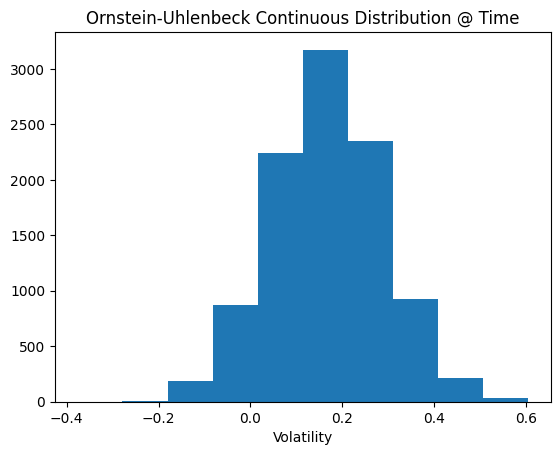

In [46]:
# define parameters
Time = 0.3
M = 10000

Z = np.random.normal(size=(M))

def mu(x, dt, kappa, theta):
    ekt = np.exp(-kappa*dt)
    return x*ekt + theta*(1-ekt)

def std(dt, kappa, sigma):
    e2kt = np.exp(-2*kappa*dt)
    return sigma*np.sqrt((1-e2kt)/(2*kappa))

drift_OU = mu(vol0, Time, kappa, theta)
diffusion_OU = std(Time, kappa, sigma)
vol_OU = drift_OU + diffusion_OU*Z

plt.hist(vol_OU)
plt.title('Ornstein-Uhlenbeck Continuous Distribution @ Time')
plt.xlabel('Volatility')
plt.show()

### Discretised SDE

Euler-Maryuama discretisation: This is an approximation of variance...

$\Delta x_{t+1} = \kappa(\theta - x_t) \Delta t + \sigma \sqrt{\Delta t} \epsilon_t$

where parameters are assigned as from above optimisation

In [47]:
# Initialise Parameters for discretization
days = 1
years = 2

dt = days/252

M = 1000
N = int(years/dt)

### Recursive function

Execution time 0.009289741516113281


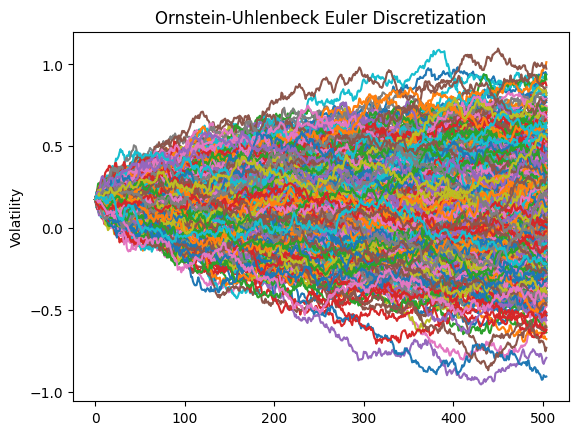

In [ ]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))

def OU_recursive(t, vol_OU):
    # Return the final state
    if t == N:
        return vol_OU

    # Thread the state through the recursive call
    else:
        drift_OU = kappa*(theta - vol_OU[t-1])*dt
        diffusion_OU = sigma*np.sqrt(dt)
        vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
        return OU_recursive(t + 1, vol_OU)


start_time = time.time()
vol_OU = OU_recursive(0, vol_OU)
print('Execution time', time.time() - start_time)
vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()

### Python Loop

Execution time 0.010604619979858398


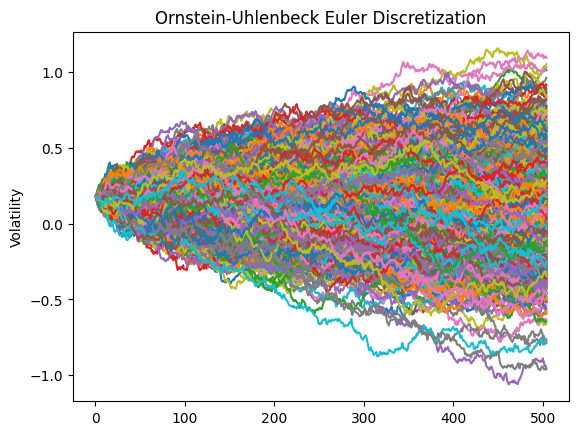

In [49]:
vol_OU = np.full(shape=(N, M), fill_value=vol0)
Z = np.random.normal(size=(N, M))

start_time = time.time()
for t in range(1,N):
    drift_OU = kappa*(theta - vol_OU[t-1])*dt
    diffusion_OU = sigma*np.sqrt(dt)
    vol_OU[t] = vol_OU[t-1] + drift_OU + diffusion_OU*Z[t]
print('Execution time', time.time() - start_time)

vol_OU = np.concatenate( (np.full(shape=(1, M), fill_value=vol0), vol_OU ) )
plt.plot(vol_OU)
plt.title('Ornstein-Uhlenbeck Euler Discretization')
plt.ylabel('Volatility')
plt.show()